In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import nibabel as nib
from PIL import Image
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
import torchsummary
from torchvision import transforms, models
import time
from sklearn.metrics import classification_report

In [3]:
label_data=np.loadtxt('/home/sumins/workspace/washout classification/min_slice/label_train.txt',dtype=int)
label_data=label_data.tolist()
label_datat=np.loadtxt('/home/sumins/workspace/washout classification/min_slice/label_test.txt',dtype=int)
label_datat=label_datat.tolist()

In [4]:
data_path='/home/sumins/workspace/washout classification/min_slice/channel4_train.nii'
channel4=[]
total=nib.load(data_path).get_fdata()
totalslice=total.shape[0]  

for i in range(0,totalslice):
    channel4.append(total[i,:,:,:])


data_patht='/home/sumins/workspace/washout classification/min_slice/channel4_test.nii'
channel4t=[]
totalt=nib.load(data_patht).get_fdata()
totalslicet=totalt.shape[0]  

for i in range(0,totalslicet):
    channel4t.append(totalt[i,:,:,:])

In [5]:
print(len(channel4))
print(len(channel4t))

1422
363


In [6]:
WINDOW_MAX = 200
WINDOW_MIN = 0
GLOBAL_PIXEL_MEAN = 0.1

class CustomDataset(Dataset): 
  def __init__(self,volume_list,all_labels,transforms=None):
    self.volume_list=volume_list
    self.all_labels=all_labels
    self.length=len(all_labels)
    self.transforms=transforms


  def __len__(self):
    return self.length


  def __getitem__(self, idx):
    npy=self.volume_list[idx]

    npy[npy > WINDOW_MAX] = WINDOW_MAX
    npy[npy < WINDOW_MIN] = WINDOW_MIN
    
    npy = (npy - WINDOW_MIN) / (WINDOW_MAX - WINDOW_MIN)
    npy -= GLOBAL_PIXEL_MEAN
    
    npy=npy.astype(dtype='float32')
    if self.transforms is not None:
      npy=self.transforms(npy)
    
    return{'npy':npy,'label':self.all_labels[idx]}

In [7]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
resnet50_pretrained=models.resnet50(pretrained=True)
print(resnet50_pretrained)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
class LiverResnet(nn.Module):
    def __init__(self,in_channels=4):
        super(LiverResnet,self).__init__()
        
        #torchvision.models에서 사전훈련된 resnet모델 가져오기
        self.model=models.resnet50(pretrained=True)
        
        #기본채널이 3이기 때문에 liver data set에 맞게 1로 바꿔줌
        #원래 resnet의 첫번째 layer
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.conv1=nn.Conv2d(in_channels,64,kernel_size=7,stride=2,padding=3,bias=False)
        
        #class수 변경
        num_ftrs=self.model.fc.in_features
        self.model.fc=nn.Linear(num_ftrs,2)

    def forward(self,x):
            return self.model(x)
        
        

In [9]:
transforms_train = transforms.Compose([transforms.ToTensor()
                                       ])
transforms_test = transforms.Compose([transforms.ToTensor()
                                       ])

hyper_param_epoch=50
hyper_param_batch=4
hyper_param_learning_rate=0.0001

In [10]:
train_dataset=CustomDataset(volume_list=channel4, all_labels=label_data,transforms=transforms_train)
train_loader = DataLoader(train_dataset, batch_size=hyper_param_batch, shuffle=True)
test_dataset=CustomDataset(volume_list=channel4t, all_labels=label_datat,transforms=transforms_train)
test_loader = DataLoader(test_dataset, batch_size=hyper_param_batch, shuffle=True)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device,"/" ,torch.cuda.device_count())

model=LiverResnet().to(device)


cuda:0 / 1


In [12]:
for param in model.parameters():
    param.requires_grad=False


In [13]:
model.model.state_dict().keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

In [14]:
for name, param in model.named_parameters():
    print(name)

model.conv1.weight
model.bn1.weight
model.bn1.bias
model.layer1.0.conv1.weight
model.layer1.0.bn1.weight
model.layer1.0.bn1.bias
model.layer1.0.conv2.weight
model.layer1.0.bn2.weight
model.layer1.0.bn2.bias
model.layer1.0.conv3.weight
model.layer1.0.bn3.weight
model.layer1.0.bn3.bias
model.layer1.0.downsample.0.weight
model.layer1.0.downsample.1.weight
model.layer1.0.downsample.1.bias
model.layer1.1.conv1.weight
model.layer1.1.bn1.weight
model.layer1.1.bn1.bias
model.layer1.1.conv2.weight
model.layer1.1.bn2.weight
model.layer1.1.bn2.bias
model.layer1.1.conv3.weight
model.layer1.1.bn3.weight
model.layer1.1.bn3.bias
model.layer1.2.conv1.weight
model.layer1.2.bn1.weight
model.layer1.2.bn1.bias
model.layer1.2.conv2.weight
model.layer1.2.bn2.weight
model.layer1.2.bn2.bias
model.layer1.2.conv3.weight
model.layer1.2.bn3.weight
model.layer1.2.bn3.bias
model.layer2.0.conv1.weight
model.layer2.0.bn1.weight
model.layer2.0.bn1.bias
model.layer2.0.conv2.weight
model.layer2.0.bn2.weight
model.layer2

In [15]:
for name,param in model.model.named_parameters():
    if name in ['layer4.0.conv1.weight', 'layer4.0.bn1.weight', 'layer4.0.bn1.bias', 'layer4.0.bn1.running_mean', 'layer4.0.bn1.running_var', 'layer4.0.bn1.num_batches_tracked', 'layer4.0.conv2.weight', 'layer4.0.bn2.weight', 'layer4.0.bn2.bias', 'layer4.0.bn2.running_mean', 'layer4.0.bn2.running_var', 'layer4.0.bn2.num_batches_tracked', 'layer4.0.conv3.weight', 'layer4.0.bn3.weight', 'layer4.0.bn3.bias', 'layer4.0.bn3.running_mean', 'layer4.0.bn3.running_var', 'layer4.0.bn3.num_batches_tracked', 'layer4.0.downsample.0.weight', 'layer4.0.downsample.1.weight', 'layer4.0.downsample.1.bias', 'layer4.0.downsample.1.running_mean', 'layer4.0.downsample.1.running_var', 'layer4.0.downsample.1.num_batches_tracked', 'layer4.1.conv1.weight', 'layer4.1.bn1.weight', 'layer4.1.bn1.bias', 'layer4.1.bn1.running_mean', 'layer4.1.bn1.running_var', 'layer4.1.bn1.num_batches_tracked', 'layer4.1.conv2.weight', 'layer4.1.bn2.weight', 'layer4.1.bn2.bias', 'layer4.1.bn2.running_mean', 'layer4.1.bn2.running_var', 'layer4.1.bn2.num_batches_tracked', 'layer4.1.conv3.weight', 'layer4.1.bn3.weight', 'layer4.1.bn3.bias', 'layer4.1.bn3.running_mean', 'layer4.1.bn3.running_var', 'layer4.1.bn3.num_batches_tracked', 'layer4.2.conv1.weight', 'layer4.2.bn1.weight', 'layer4.2.bn1.bias', 'layer4.2.bn1.running_mean', 'layer4.2.bn1.running_var', 'layer4.2.bn1.num_batches_tracked', 'layer4.2.conv2.weight', 'layer4.2.bn2.weight', 'layer4.2.bn2.bias', 'layer4.2.bn2.running_mean', 'layer4.2.bn2.running_var', 'layer4.2.bn2.num_batches_tracked', 'layer4.2.conv3.weight', 'layer4.2.bn3.weight', 'layer4.2.bn3.bias', 'layer4.2.bn3.running_mean', 'layer4.2.bn3.running_var', 'layer4.2.bn3.num_batches_tracked', 'fc.weight', 'fc.bias']:
        param.requires_grad=True


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()), lr=hyper_param_learning_rate)
checkpoint = torch.load('/home/sumins/workspace/washout classification/model_save/transfer_1.pth')
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

<All keys matched successfully>

In [17]:
def validation_loss(model):
    model.eval()
    correct = 0
    total = 0
    total_loss=0
    True_pred=0
    for i_batch, item in enumerate(test_loader):
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
 
        outputs =model(npys)
        loss = criterion(outputs, labels)
        total_loss+=loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += len(labels)
        correct += (predicted == labels).sum().item()
        for k in predicted:
            if k==1:
                True_pred+=1
    model.train()    
     
    return total_loss/(i_batch+1),100 * correct / total, True_pred



In [18]:
loss_value=1
start=time.time()
model.train()
train_loss_history=[]
valid_loss_history=[]
val_loss=0
acc=50
for e in range(hyper_param_epoch):
        correct=0
        total=0
        for i_batch, item in enumerate(train_loader):
                npys = item['npy'].to(device)
                labels = item['label'].to(device)
                #print(npys)
                # Forward pass
                outputs =model(npys)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total += len(labels)
                correct += (predicted == labels).sum().item()
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        val_loss,val_accuracy, True_predict=validation_loss(model)
        print(True_predict)
        train_loss_history.append(loss.item())
        valid_loss_history.append(val_loss)
        print('Epoch [{}/{}],i_batch={} ,Train_Loss: {:.4f},Train_acc: {:.2f}Valid_loss: {:.4f}, Valid_acc: {:.2f}'
                                        .format(e + 1, hyper_param_epoch, i_batch+1, loss.item(), 100*correct/total,val_loss, val_accuracy))
        print("Time: {}sec".format(time.time()-start))
        start=time.time()
        if loss_value>val_loss:
                loss_value=val_loss
                torch.save({
                'epoch': e,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item(),
                }, '/home/sumins/workspace/washout classification/model_save/transfer_second_freeze.pth')
        if val_accuracy>acc:
                acc=val_accuracy
                torch.save({
                'epoch': e,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item(),
                }, '/home/sumins/workspace/washout classification/model_save/transfer_second_freeze_acc.pth')
                


344
Epoch [1/50],i_batch=356 ,Train_Loss: 0.5451,Train_acc: 75.39Valid_loss: 0.7273, Valid_acc: 68.04
Time: 398.0995261669159sec
185
Epoch [2/50],i_batch=356 ,Train_Loss: 0.3812,Train_acc: 82.91Valid_loss: 0.9322, Valid_acc: 51.24
Time: 268.2618627548218sec
193
Epoch [3/50],i_batch=356 ,Train_Loss: 0.1473,Train_acc: 87.69Valid_loss: 0.9138, Valid_acc: 50.69
Time: 278.890234708786sec
273
Epoch [4/50],i_batch=356 ,Train_Loss: 1.4842,Train_acc: 90.51Valid_loss: 1.0772, Valid_acc: 58.40
Time: 283.9459125995636sec
290
Epoch [5/50],i_batch=356 ,Train_Loss: 3.0702,Train_acc: 92.41Valid_loss: 0.9657, Valid_acc: 63.09
Time: 285.1948986053467sec
288
Epoch [6/50],i_batch=356 ,Train_Loss: 0.0050,Train_acc: 94.16Valid_loss: 0.9770, Valid_acc: 63.64
Time: 279.7242398262024sec
238
Epoch [7/50],i_batch=356 ,Train_Loss: 0.0386,Train_acc: 96.20Valid_loss: 1.3318, Valid_acc: 51.52
Time: 275.4696133136749sec
186
Epoch [8/50],i_batch=356 ,Train_Loss: 0.8770,Train_acc: 96.91Valid_loss: 1.7608, Valid_acc: 46

KeyboardInterrupt: 

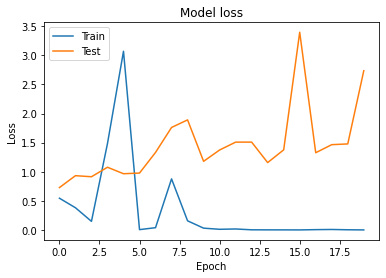

In [19]:
plt.plot(train_loss_history)
plt.plot(valid_loss_history)
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [20]:
import csv


with open("valid_second_freeze.csv", 'w') as file:
  writer = csv.writer(file)
  writer.writerow(valid_loss_history)


In [21]:
import csv


with open("train_second_freeze.csv", 'w') as file:
  writer = csv.writer(file)
  writer.writerow(train_loss_history)


In [23]:
true_label=[]
pred_label=[]

model=LiverResnet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_param_learning_rate)

checkpoint = torch.load('/home/sumins/workspace/washout classification/model_save/transfer_second_freeze.pth')
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(loss)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for item in test_loader:
        npys = item['npy'].to(device)
        labels = item['label'].to(device)
        
        outputs =model(npys)
        _, predicted = torch.max(outputs.data, 1)
        true_label.extend(labels)
        pred_label.extend(predicted)
        total += len(labels)
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))

0.5450759530067444
Test Accuracy of the model on the 363 test images: 68.04407713498622 %


In [24]:
true_labels=torch.tensor(true_label)
true_labels=true_labels.tolist()
pred_labels=torch.tensor(pred_label)
pred_labels=pred_labels.tolist()
print(classification_report(true_labels,pred_labels))

              precision    recall  f1-score   support

           0       0.16      0.03      0.05       103
           1       0.71      0.94      0.81       260

    accuracy                           0.68       363
   macro avg       0.43      0.48      0.43       363
weighted avg       0.55      0.68      0.59       363



: 